# Interacting with CLIP 

Adapted from the notebook https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

### Install pytorch and these prereqs

In [24]:
#%pip install ftfy regex tqdm
#%pip install git+https://github.com/openai/CLIP.git


In [25]:
# Import necessary libraries
import os
import re
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

#Function to Generate Descriptions from Filenames

In [26]:
def generate_description(filename):
    """
    Generate a text description from a filename.
    Removes '.png' extension and any numbers.
    """
    description = re.sub(r'\d+', '', filename.replace('.png', ''))
    return description.replace('_', ' ').strip()


In [27]:
model, preprocess = clip.load("ViT-L/14")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [28]:
ls location_descriptions

 Datentr�ger in Laufwerk C: ist Windows
 Volumeseriennummer: D695-93B7

 Verzeichnis von c:\Pokemon\PokemonRedExperiments\clip_experiment\location_descriptions

12.02.2024  23:09    <DIR>          .
12.02.2024  23:21    <DIR>          ..
12.02.2024  21:40             6.366 fight_geodude_no_pp_for_attack.png
12.02.2024  11:01           130.405 fight_rat.png
12.02.2024  11:01           131.127 fight_squirtle.png
12.02.2024  21:40             6.210 fight_zubat.png
12.02.2024  21:40             7.320 healing_pokemon_in_pokecenter.png
12.02.2024  11:01           162.317 meeting_inside_oaks_office.png
12.02.2024  21:40             9.259 standing_in_a_cave_options_open.png
12.02.2024  11:01           197.870 standing_in_a_room_on_tiled_floor.png
12.02.2024  11:01           214.184 walking_around_town.png
12.02.2024  11:01           403.797 walking_in_tall_grass.png
12.02.2024  21:40             6.173 walking_on_short_grass.png
              11 Datei(en),      1.275.028 Bytes
               2 

In [29]:
img_loc = 'location_descriptions'  # Path to your images directory
descriptions = {}

# Group filenames by generated description
for filename in os.listdir(img_loc):
    if filename.endswith('.png'):
        desc = generate_description(filename)
        if desc not in descriptions:
            descriptions[desc] = []
        descriptions[desc].append(filename)

# Prepare images and texts for processing
original_images = []
images = []  # Preprocessed images
texts = []  # Text descriptions

for desc, filenames in descriptions.items():
    for filename in filenames:
        image_path = os.path.join(img_loc, filename)
        image = Image.open(image_path).convert("RGB")
        original_images.append(image)
        images.append(preprocess(image))
        texts.append("black and white pixel art " + desc)



In [30]:
# Convert images list to tensor for model processing
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(texts)

# Calculate image and text features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()


In [31]:
# Normalize features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate similarity
similarity = (text_features.cpu().numpy() @ image_features.cpu().numpy().T)



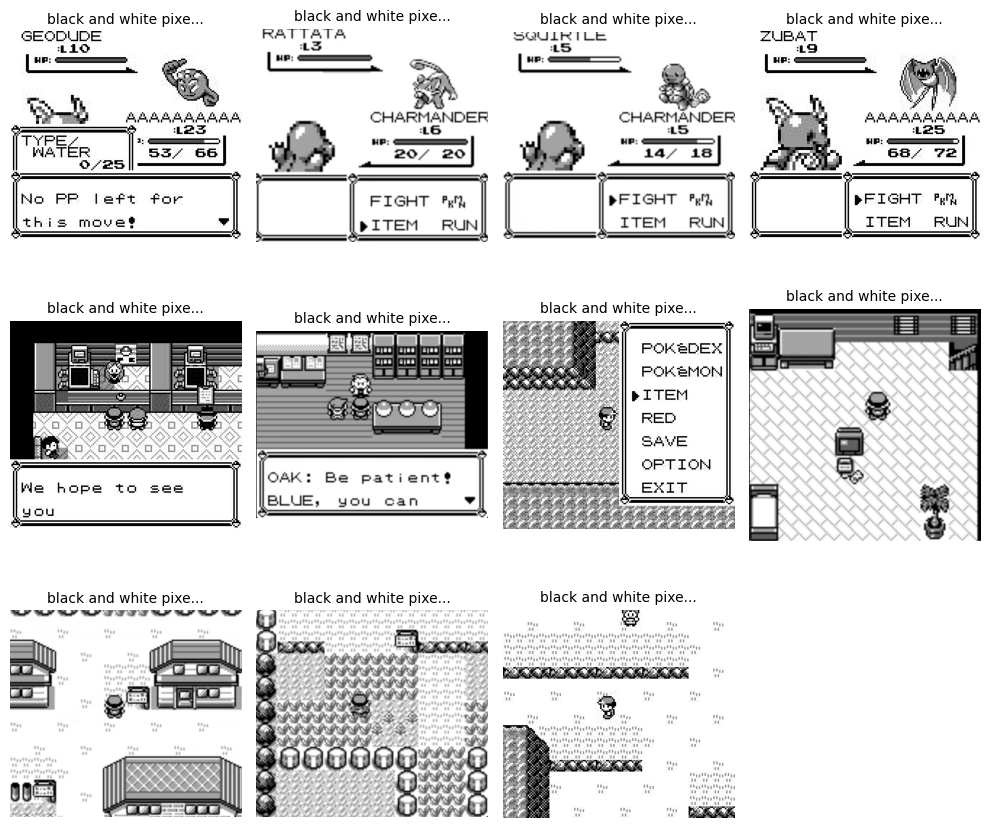

In [32]:
# Calculate the number of images and set up the subplot dimensions
num_images = len(original_images)
num_cols = 4  # Choose how many columns you want in the plot
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed

plt.figure(figsize=(2.5 * num_cols, 3 * num_rows))  # Adjust figure size based on num of images

for i, (desc, image) in enumerate(zip(texts, original_images)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)
    plt.title(f"{desc[:20]}...", fontsize=10)  # Truncate long descriptions
    plt.axis('off')

plt.tight_layout()
plt.show()



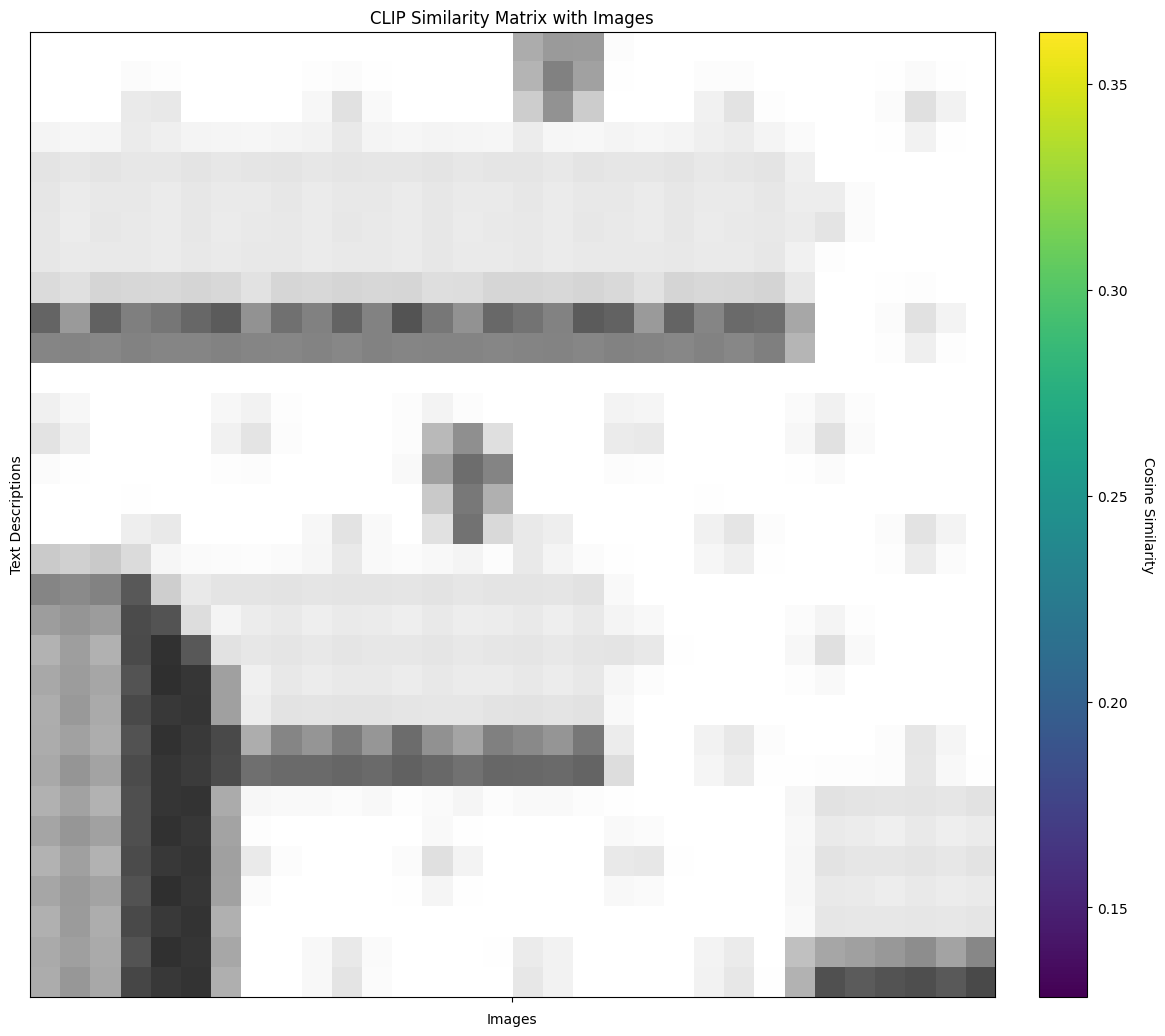

In [33]:
# Adjust the list comprehension if original_images only contains Image objects
resized_images = [img.resize((32, 32)) for img in original_images]  # Resize images to 32x32 for display

# Plot similarity matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(similarity, aspect='auto', cmap='viridis')

# Add color bar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

# Set ticks
ax.set_xticks(np.arange(len(resized_images)))
ax.set_yticks(np.arange(len(texts)))
ax.set_xticklabels([''] * len(resized_images))  # Hide x labels to make room for images
ax.set_yticklabels(texts)

# Plot images at tick locations
for i, img in enumerate(resized_images):
    ax.imshow(img, extent=(i-0.5, i+0.5, -1.5, -0.5))  # Adjust these values as needed

# Rotate tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Avoid clipping of tick labels
plt.tight_layout()

# Set labels and title
ax.set_xlabel('Images')
ax.set_ylabel('Text Descriptions')
ax.set_title('CLIP Similarity Matrix with Images')
plt.show()

